# [A] Install Dependencies and GPU Implementation Setup

In [21]:
!pip install tensorflow==2.8 tensorflow-gpu==2.8 opencv-python matplotlib protobuf==3.19.1
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

import os 
import tensorflow as tf

# Avoid 'Out of Memory' errors by setting GPU memory consumption growth.
gpu_var = tf.config.experimental.list_physical_devices('GPU')
for gpu_use in gpu_var:
    tf.config.experimental.set_memory_growth(gpu_use, True)
    
# Configure GPU for use by CNN; makes training a lot faster. 
tf.config.list_physical_devices('GPU')


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# [B] Image Filtering Stage

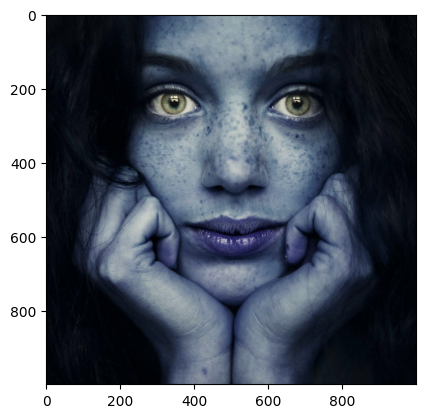

In [29]:
import cv2
import imghdr
from matplotlib import pyplot as plt

# Setting data collection variable.
data_directory = 'data'

# Setting acceptable image types.
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

# Show image plotted out. Example image from "people' dataset. 
img = cv2.imread(os.path.join('data', 'people', '9pres.jpg'))
plt.imshow(img)

# Image is about 1000 x 1000 and needs to be re-sized for the complexity of our CNN model. 

In [62]:
# Runs images of both classes through and removes images that will not work.
# Removes images without correct extension type, as defined in previous block. 
for class_of_image in os.listdir(data_directory): 
    for chosen_image in os.listdir(os.path.join(data_directory, class_of_image)):
        path_of_image = os.path.join(data_directory, class_of_image, chosen_image)
        try:
            img = cv2.imread(path_of_image)
            correct_extension = imghdr.what(path_of_image)
            if correct_extension not in image_extensions:
                # Outputs extension reason for dismissal from training. 
                print('Image is of an inacceptable extension {}'.format(path_of_image))
                # Removes image from directory
                os.remove(path_of_image)
        except Exception as e:
            # Outputs any other reason for dismissal from training. 
            print('This image has an issue {}'.format(path_of_image))

# [C] Data Loading Stage

In [85]:
import numpy as np
from matplotlib import pyplot as plt

# Builds image dataset using Keras utility; builds data pipeline.
data = tf.keras.utils.image_dataset_from_directory('data')

# Allows access to data pipeline constructed above.
iterator_of_data = data.as_numpy_iterator()

# Accesses the data pipeline; gets another batch of images from iterator)
batch = iterator_of_data.next()

#Output lists number of files and number of classes those files are child of. 

Found 467 files belonging to 2 classes.


### [C.1] Data Plotting and Array Representation

In [86]:
# Shows loaded batch as an array. Running block [51] again will shuffle batch.
# Class 0 = 'Person'
# Class 1 = 'Wasp'
batch[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

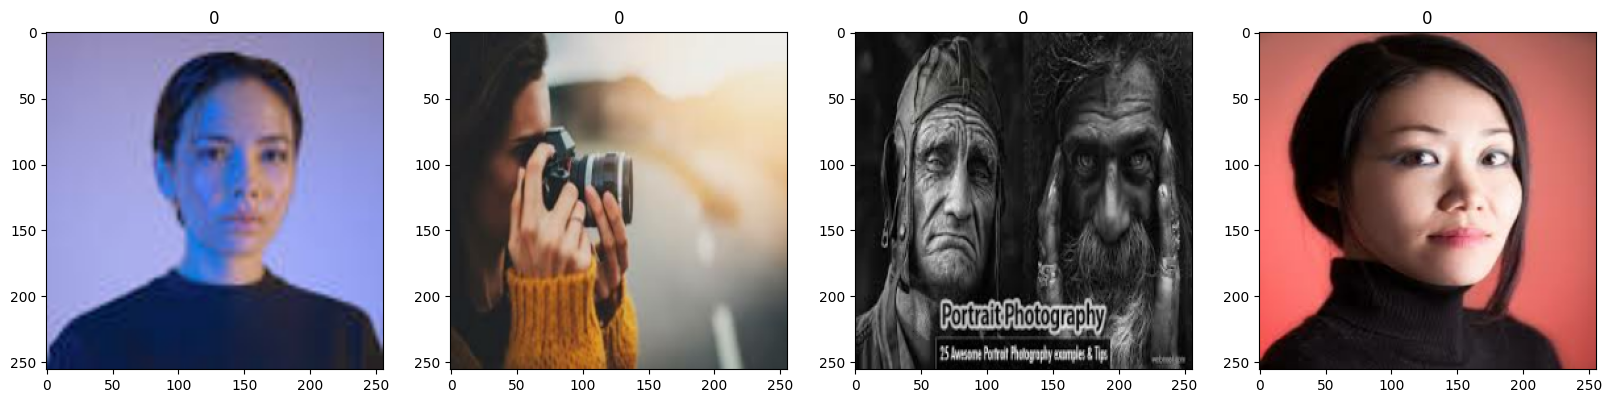

In [87]:
# Plotting images from loaded batch with class label. Running block [51] again will shuffle batch. 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# [D] Data Scaling Stage

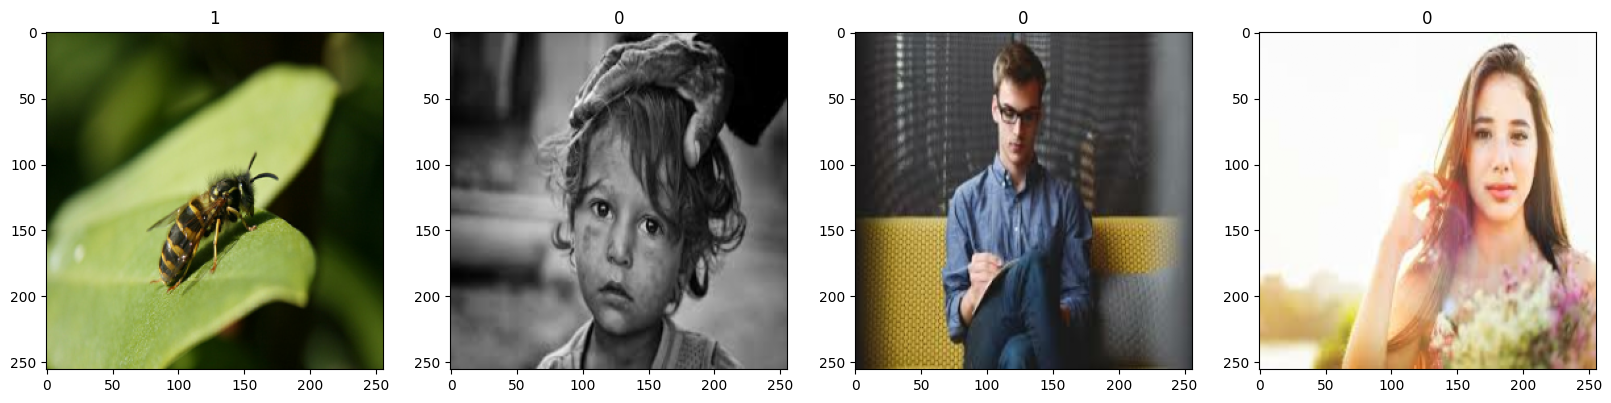

In [88]:
# x = images, y = target variable
data = data.map(lambda x,y: (x/255, y))

# Scaling of batch
sc_iterator = data.as_numpy_iterator()
batch = sc_iterator.next()

# Used for testing; want to ensure scaling does not make images blurry.
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# [E] Data Partition Split Stage

In [89]:
# Show number of image batches available for partitioning; should be 15.  
len(data)

15

In [90]:
# Allocates 10 image batches to training sample partition
# Training set standard is to have 70%
training_partition = int(len(data)*.7)
# Allocates 3 image batches to validation sample partition
# Training set standard is to have 20%
validation_partition = int(len(data)*.2)
# Allocates 2 image batches to testing sample partition
# Training set standard is to have 10%. Added 1 to include all batches. Training now has 13.3% representation.  
testing_partition = int(len(data)*.1)+1

# Allocates training_partition number of batches for training (in this case it is 10 batches)
training = data.take(training_partition)
# Skips batches allocated to the training partition. Allocates validation_partition number of batches for validation (3 batches)
validation = data.skip(training_partition).take(validation_partition)
# Skeps batches allocted to training and validation partition. Allocates testing_partition number of batches for testing (2 batches)
testing = data.skip(validation_partition+training_partition).take(testing_partition)

# User to test partition allocation sizes
print('Training partition = ',training_partition)
print('Validation partition = ',validation_partition)
print('Testing partition = ',testing_partition)
# Total batches should match len(data) = 243. ~And it does~
print('Total = ', training_partition + validation_partition + testing_partition)

Training partition =  10
Validation partition =  3
Testing partition =  2
Total =  15


# [F] Convolutional Neural Network Build

In [91]:
# Import dependencies: models and layers for CNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

model = Sequential()

# ~~~~~~ CNN MODEL ~~~~~~
# Defines input confines for first layer. Convolution layer contains 16 filters of size 3 x 3 pixels. Stride set to 1 (filter moves one pixel at a time).
# Input is defined as 256 x 256 image. 
# relu activation type passes image through, converting values to be positive. 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# When image has passed through first filter, the pooling stage condenses 3 x 3 image data into 2 x 2 region and extracts/passes on max value in that condensed region. 
model.add(MaxPooling2D())

# Defines input confies for second convolution layer. Layer is composed of 32 filters. 
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# Pooling confines for second layer. 
model.add(MaxPooling2D())

# Image values are flattened. 
model.add(Flatten())

# Fully connected layer (dense layer) of activation type relu. 
model.add(Dense(256, activation='relu'))
# Fully connected layer (dense layer) of activation type sigmoid. Defines output as one item.  
model.add(Dense(1, activation='sigmoid'))

# ~~~~~~ COMPILER ~~~~~~

# Used to compile the above model. Uses 'adam' optimizer. 
# Specifies 'loss' 
# Metric we are tracking is accuracy. Tells us how well the model is classifying images as 0, 1. 

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Provides summary of parameters for the above defined neural network. 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 123008)            0         
                                                                 
 dense_4 (Dense)             (None, 256)              

# [G] CNN Training Stage

In [92]:
# Creates log directory. 
logdir='logs'

# Creates callback to save model at specific testing milestones while the model trains. Logs this information in above defined log file.  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Epochs is the number of times we run through entire training set. (So for our case this is 20 times). Can be increased for additional learning. 
# Passes through validation data for evaluation.
# Passes through callback defined above. Logs all performance information to Tensorboard. 
# Optional variable for altering batch size: batch_size=10
training_history = model.fit(training, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 4s 267ms/step - loss: 3.6344 - accuracy: 0.5750 - val_loss: 0.6343 - val_accuracy: 0.7188
Epoch 2/20
10/10 [==============================] - 4s 284ms/step - loss: 0.4731 - accuracy: 0.8156 - val_loss: 0.4226 - val_accuracy: 0.8229
Epoch 3/20
10/10 [==============================] - 4s 282ms/step - loss: 0.3286 - accuracy: 0.9062 - val_loss: 0.2273 - val_accuracy: 0.9062
Epoch 4/20
10/10 [==============================] - 4s 273ms/step - loss: 0.2017 - accuracy: 0.9156 - val_loss: 0.1963 - val_accuracy: 0.9479
Epoch 5/20
10/10 [==============================] - 4s 274ms/step - loss: 0.1218 - accuracy: 0.9719 - val_loss: 0.1132 - val_accuracy: 0.9688
Epoch 6/20
10/10 [==============================] - 4s 275ms/step - loss: 0.0849 - accuracy: 0.9844 - val_loss: 0.0629 - val_accuracy: 0.9792
Epoch 7/20
10/10 [==============================] - 4s 273ms/step - loss: 0.0487 - accuracy: 0.9906 - val_loss: 0.0371 - val_accuracy: 0.9896
Epoch 

# [H] Performance Plotting

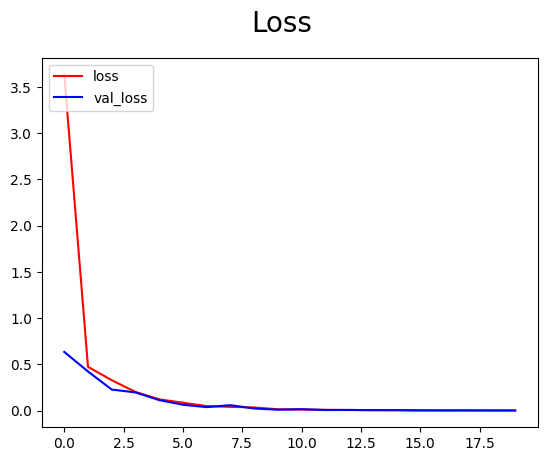

In [93]:
# Plots performance of recent model test; Loss and Validation loss
fig = plt.figure()
# Loss shows as red line.
plt.plot(training_history.history['loss'], color='red', label='loss')
# Validation Loss shows as blue line. 
# If val_loss is going up and loss is going down this is a classic example of overfitting.
plt.plot(training_history.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
# Outputs chart
plt.show()

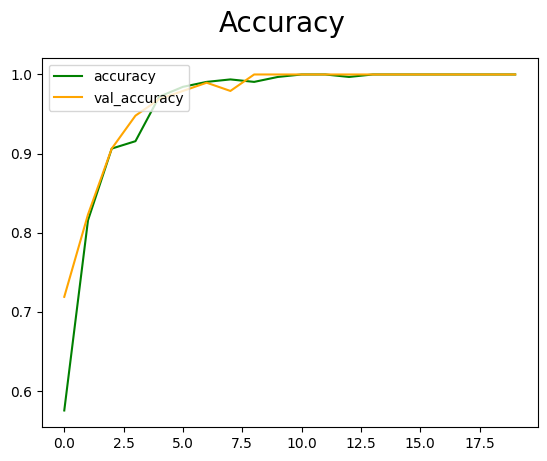

In [95]:
# Plots performance of recent model test; Loss and Validation loss
fig = plt.figure()
# Accuracy shows as green line.
plt.plot(training_history.history['accuracy'], color='green', label='accuracy')
# Validation Accuracy shows as orange line.
plt.plot(training_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
# Outputs chart
plt.show()

# [I] Model Evaluation 

In [102]:
# import dependencies from tensorflow.keras
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Recall

# Define evaluation metrics
precision_metric = Precision()
accuracy_metric = BinaryAccuracy()
recall_metric = Recall()

# Applies evaluation metrics to recent tested batches. Defines prediction value dec_value as x. 
for batch in testing.as_numpy_iterator():
    x, y = batch
    dec_value = model.predict(x)
    precision_metric.update_state(y, dec_value)
    accuracy_metric.update_state(y, dec_value)
    recall_metric.update_state(y, dec_value)
    
# Outputs rating of model based on its precision, accuracy, and recall during testing. 
print(f'Precision: {precision_metric.result().numpy()} \nRecall: {recall_metric.result().numpy()} \nAccuracy: {accuracy_metric.result().numpy()}')

Precision: 1.0 
Recall: 1.0 
Accuracy: 1.0


# [J] Testing Stage

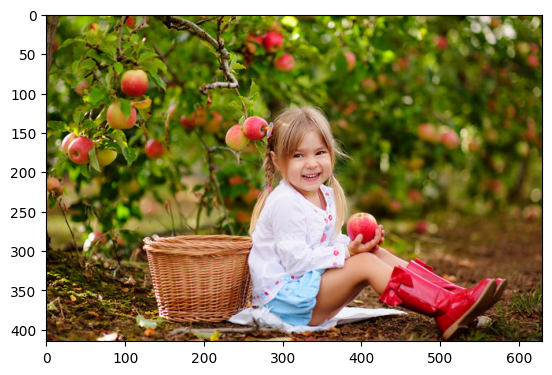

In [246]:
# import cv2 for testing
import cv2

# Allows input of testing image that has been uploaded to directory.
testing_img = cv2.imread('persontest.jpg') 
# Shows image in standard BGR color. 
plt.imshow(cv2.cvtColor(testing_img, cv2.COLOR_BGR2RGB))
plt.show()

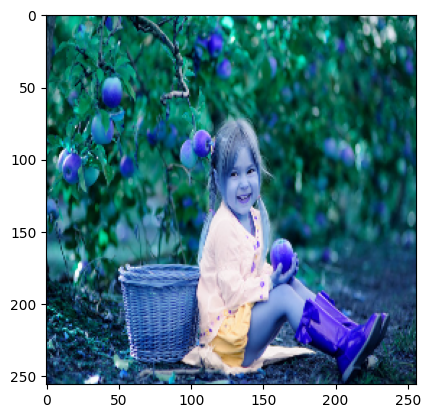

In [247]:
# Resizes image for comparison against testing partition. 
resized_img = tf.image.resize(testing_img, (256,256))
plt.imshow(resized_img.numpy().astype(int))
# Displays plotted test image for confirmation.
plt.show()

In [248]:
# Defines dec_value as prediction variable of the resized image. 
dec_value = model.predict(np.expand_dims(resized_img/255, 0))

# Outputs array value (x = dec_value, y) for the resized image. 
# 0 <---- 0.5 = Person
# 0.5 ----> 1 = Wasp
dec_value

array([[6.1318274e-13]], dtype=float32)

In [249]:
# Prediction if-else statement
if dec_value > 0.5:
    # If model detects it is looking at a wasp, later implementation will tell robot to spray insecticide
    print(f'This image is of a wasp!')
    print(f'Robot fire at will!')
else:
    # If model detects it is looking at a person, later implementation will tell robot to stand down and say hello
    print(f'This image is of a person!')
    print(f'Robot stand down and say hello!')

This image is of a person!
Robot stand down and say hello!


# [K] Model Save Stage

In [250]:
# If we like the model's metrics and want to save it we can use the following code
from tensorflow.keras.models import load_model

# Saves model to 'models' folder. 
model.save(os.path.join('models','capstoneproject.h5'))
model_new = load_model(os.path.join('models','capstoneproject.h5'))

# Pass resized image through saved model.
dec_value_new = model_new.predict(np.expand_dims(resized_img/255, 0))
# Outputs array value (x = dec_value, y) for the resized image. 
# 0 <---- 0.5 = Person
# 0.5 ----> 1 = Wasp

In [251]:
# Prediction if-else statement for dec_value_new
if dec_value_new > 0.5:
    # If model detects it is looking at a wasp, later implementation will tell robot to spray insecticide
    print(f'This image is of a wasp!')
    print(f'Robot fire at will!')
else:
    # If model detects it is looking at a person, later implementation will tell robot to stand down and say hello
    print(f'This image is of a person!')
    print(f'Robot stand down and say hello!')

This image is of a person!
Robot stand down and say hello!
